# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_155  P01624                     23.083
Sample_041  Q5VSG8                     16.473
Sample_074  P23142                     20.472
Sample_178  P54289;P54289-4;P54289-5   19.364
Sample_188  Q9BUJ0                     16.097
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups
Sample_041  D6R956;P09936    14.971
Sample_052  J3KNE3;P68402    12.550
Sample_199  Q5T848           16.765
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.240
            A0A075B6Q5                 12.811
            A0A075B6R2                 12.962
            A0A075B6S5                 13.833
            A0A087WSY4                 14.620
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.209
            Q9UI40;Q9UI40-2            13.157
            Q9UIW2                     12.706
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.163
            Q9UP79                     12.774
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.023,15.050,16.842,19.863,15.634,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.391,19.067,...,15.528,15.576,14.131,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.670,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.593,17.705,17.039,16.412,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,16.030,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.671,15.345,17.084,18.708,14.249,19.433,12.071,11.105
Sample_207,15.739,16.877,15.469,16.898,15.311,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.090,14.169,12.609,12.629,12.899,11.718,13.249,12.008,11.851,13.504
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.720,19.067,16.127,...,11.315,13.665,12.927,12.274,11.335,12.151,12.402,12.500,13.069,12.193
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.511,12.279,13.017,12.040,13.323,12.972,12.122,11.957,12.520,12.801
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.520,12.804,12.496,11.513,12.763,12.405,13.225,14.050,13.543,12.315
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.698,12.587,12.864,12.706,13.907,12.742,13.898,13.433,12.212,12.545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.785,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 385.44it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.95it/s]

100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.09it/s]

100%|██████████| 3/3 [00:00<00:00,  4.56it/s]

100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.37it/s]

100%|██████████| 4/4 [00:00<00:00,  4.75it/s]

100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.82it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.51it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.58it/s]

100%|██████████| 5/5 [00:01<00:00,  4.29it/s]

100%|██████████| 5/5 [00:01<00:00,  4.73it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.55it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.93it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.37it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.74it/s]

100%|██████████| 6/6 [00:01<00:00,  4.27it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.52it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.62it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.91it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.23it/s]

100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

100%|██████████| 7/7 [00:01<00:00,  4.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.27it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.02it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.68it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.21it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.07it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.96it/s]

100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.14it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.01it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.66it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.61it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.53it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.45it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.26it/s]

100%|██████████| 9/9 [00:03<00:00,  2.30it/s]

100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.98it/s]

 30%|███       | 3/10 [00:00<00:01,  6.80it/s]

 40%|████      | 4/10 [00:00<00:01,  5.35it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.62it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.45it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.62it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.48it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.23it/s]

100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

100%|██████████| 10/10 [00:02<00:00,  4.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.46it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.81it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.43it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.25it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.15it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.15it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.48it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.45it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.53it/s]

100%|██████████| 11/11 [00:02<00:00,  4.87it/s]

100%|██████████| 11/11 [00:02<00:00,  5.09it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.63it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.69it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.53it/s]

 42%|████▏     | 5/12 [00:00<00:01,  5.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.86it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.67it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.53it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.07it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.05it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.20it/s]

100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

100%|██████████| 12/12 [00:02<00:00,  4.68it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 11.93it/s]

 31%|███       | 4/13 [00:00<00:01,  6.22it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.68it/s]

 46%|████▌     | 6/13 [00:01<00:01,  5.18it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.86it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.38it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.55it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.40it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.46it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.82it/s]

100%|██████████| 13/13 [00:02<00:00,  4.94it/s]

100%|██████████| 13/13 [00:02<00:00,  5.04it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.96it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.36it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.80it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.23it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.94it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.92it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.84it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.97it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.10it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.42it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.58it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.66it/s]

100%|██████████| 14/14 [00:04<00:00,  3.89it/s]

100%|██████████| 14/14 [00:04<00:00,  3.47it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.20it/s]

 20%|██        | 3/15 [00:00<00:01,  6.35it/s]

 27%|██▋       | 4/15 [00:00<00:01,  5.54it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.82it/s]

 40%|████      | 6/15 [00:01<00:02,  4.00it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.83it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.89it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.85it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.63it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.34it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.20it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.12it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.32it/s]

100%|██████████| 15/15 [00:03<00:00,  3.49it/s]

100%|██████████| 15/15 [00:03<00:00,  3.83it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.047 0.017          0.639 0.420       0.084   
2             0.004 0.002      0.041 0.012          0.807 0.092       0.718   
3             0.004 0.004      0.051 0.017          0.793 0.091       0.701   
4             0.003 0.000      0.037 0.006          0.791 0.092       0.748   
5             0.004 0.003      0.049 0.019          0.780 0.095       0.725   
6             0.005 0.005      0.056 0.021          0.776 0.091       0.716   
7             0.004 0.004      0.041 0.011          0.769 0.086       0.723   
8             0.007 0.006      0.068 0.027          0.802 0.078       0.771   
9             0.007 0.006      0.061 0.027          0.801 0.080       0.766   
10            0.003 0.001      0.036 0.009          0.803 0.075       0.801   
11            0.002 0.000      0.022 0.004          0.803 0.076       0.796   
12            0.003 0.000      0.034 0.008          0.804 0.077       0.789   
13            0.004 0.002      0.035 0.008          0.799 0.086       0.776   
14            0.006 0.005      0.051 0.024          0.800 0.084       0.775   
15            0.004 0.000      0.038 0.012          0.795 0.085       0.773   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.080   0.142 0.123                  0.535 0.037        0.855   
2          0.082   0.756 0.067                  0.794 0.054        0.871   
3          0.092   0.739 0.068                  0.781 0.054        0.865   
4          0.095   0.763 0.069                  0.799 0.057        0.871   
5          0.129   0.744 0.089                  0.785 0.071        0.889   
6          0.122   0.738 0.085                  0.780 0.067        0.888   
7          0.115   0.739 0.077                  0.780 0.061        0.885   
8          0.099   0.782 0.070                  0.815 0.058        0.902   
9          0.099   0.779 0.071                  0.812 0.058        0.902   
10         0.089   0.799 0.063                  0.828 0.054        0.907   
11         0.091   0.796 0.061                  0.825 0.052        0.904   
12         0.093   0.792 0.064                  0.823 0.053        0.904   
13         0.098   0.783 0.071                  0.815 0.059        0.902   
14         0.097   0.783 0.069                  0.815 0.058        0.902   
15         0.094   0.780 0.068                  0.812 0.057        0.900   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.826 0.089        210.000 0.000  
2          0.048                  0.818 0.083        210.000 0.000  
3          0.051                  0.808 0.083        210.000 0.000  
4          0.053                  0.813 0.086        210.000 0.000  
5          0.048                  0.841 0.071        210.000 0.000  
6          0.048                  0.837 0.075        210.000 0.000  
7          0.048                  0.834 0.074        210.000 0.000  
8          0.046                  0.874 0.064        210.000 0.000  
9          0.046                  0.876 0.064        210.000 0.000  
10         0.045                  0.886 0.059        210.000 0.000  
11         0.047                  0.881 0.062        210.000 0.000  
12         0.048                  0.881 0.063        210.000 0.000  
13         0.049                  0.882 0.063        210.000 0.000  
14         0.049                  0.881 0.063        210.000 0.000  
15         0.049                  0.879 0.062 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 512.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.38it/s]

100%|██████████| 2/2 [00:00<00:00,  6.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.95it/s]

100%|██████████| 3/3 [00:00<00:00,  3.41it/s]

100%|██████████| 3/3 [00:00<00:00,  3.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.85it/s]

100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.54it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.95it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.76it/s]

100%|██████████| 5/5 [00:01<00:00,  2.48it/s]

100%|██████████| 5/5 [00:01<00:00,  2.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.40it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.98it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.29it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.88it/s]

100%|██████████| 6/6 [00:01<00:00,  2.75it/s]

100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.74it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.82it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.81it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.96it/s]

100%|██████████| 7/7 [00:02<00:00,  3.19it/s]

100%|██████████| 7/7 [00:02<00:00,  3.29it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.00it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.72it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.82it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.92it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.33it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.03it/s]

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

100%|██████████| 8/8 [00:02<00:00,  3.49it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.44it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.03it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.55it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.24it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  2.84it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.65it/s]

100%|██████████| 9/9 [00:02<00:00,  2.81it/s]

100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.31it/s]

 30%|███       | 3/10 [00:00<00:01,  5.34it/s]

 40%|████      | 4/10 [00:00<00:01,  4.22it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.28it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.03it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.40it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.86it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.77it/s]

100%|██████████| 10/10 [00:02<00:00,  2.82it/s]

100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.09it/s]

 36%|███▋      | 4/11 [00:00<00:00,  7.02it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.17it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.70it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.02it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.13it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  3.65it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.07it/s]

100%|██████████| 11/11 [00:02<00:00,  3.20it/s]

100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.54it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.72it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.79it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.35it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.01it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.88it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.27it/s]

 75%|███████▌  | 9/12 [00:02<00:01,  2.97it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.97it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.74it/s]

100%|██████████| 12/12 [00:03<00:00,  2.81it/s]

100%|██████████| 12/12 [00:03<00:00,  3.42it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.52it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.37it/s]

 31%|███       | 4/13 [00:00<00:01,  4.86it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.38it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.17it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.04it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.12it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.85it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.00it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.21it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.01it/s]

100%|██████████| 13/13 [00:03<00:00,  2.77it/s]

100%|██████████| 13/13 [00:03<00:00,  3.62it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.91it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.52it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.22it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.07it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.83it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.88it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.83it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.85it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.96it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.98it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.81it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.43it/s]

100%|██████████| 14/14 [00:03<00:00,  3.00it/s]

100%|██████████| 14/14 [00:03<00:00,  3.69it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.27it/s]

 20%|██        | 3/15 [00:00<00:03,  3.47it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.00it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.76it/s]

 40%|████      | 6/15 [00:01<00:03,  2.79it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.02it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.27it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.36it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.42it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.60it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.73it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.66it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.58it/s]

100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

100%|██████████| 15/15 [00:04<00:00,  3.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.001      0.039 0.009          0.010 0.071       0.001   
2             0.004 0.002      0.044 0.017          0.703 0.121       0.522   
3             0.004 0.002      0.041 0.012          0.690 0.136       0.501   
4             0.006 0.006      0.056 0.022          0.675 0.128       0.509   
5             0.005 0.004      0.057 0.025          0.732 0.089       0.620   
6             0.004 0.003      0.044 0.015          0.719 0.087       0.615   
7             0.003 0.001      0.029 0.011          0.794 0.101       0.783   
8             0.004 0.004      0.043 0.015          0.786 0.105       0.772   
9             0.004 0.002      0.041 0.013          0.791 0.104       0.773   
10            0.003 0.002      0.035 0.008          0.827 0.104       0.795   
11            0.004 0.003      0.046 0.015          0.848 0.091       0.803   
12            0.004 0.002      0.040 0.011          0.844 0.093       0.794   
13            0.004 0.002      0.033 0.010          0.842 0.095       0.801   
14            0.005 0.004      0.044 0.015          0.850 0.091       0.805   
15            0.004 0.003      0.041 0.016          0.848 0.092       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.864   
2          0.134   0.589 0.114                  0.678 0.077        0.736   
3          0.128   0.568 0.107                  0.662 0.068        0.744   
4          0.133   0.568 0.108                  0.660 0.067        0.742   
5          0.113   0.666 0.081                  0.726 0.058        0.790   
6          0.111   0.657 0.080                  0.718 0.059        0.786   
7          0.102   0.783 0.076                  0.814 0.064        0.902   
8          0.111   0.773 0.084                  0.806 0.068        0.900   
9          0.112   0.776 0.086                  0.810 0.069        0.900   
10         0.101   0.804 0.074                  0.833 0.061        0.922   
11         0.110   0.818 0.076                  0.846 0.061        0.928   
12         0.109   0.812 0.077                  0.841 0.062        0.927   
13         0.105   0.815 0.075                  0.843 0.062        0.929   
14         0.105   0.821 0.072                  0.848 0.060        0.929   
15         0.108   0.819 0.074                  0.847 0.061        0.929   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.832 0.087        210.000 0.000  
2          0.079                  0.669 0.098        210.000 0.000  
3          0.073                  0.704 0.093        210.000 0.000  
4          0.070                  0.689 0.091        210.000 0.000  
5          0.064                  0.761 0.083        210.000 0.000  
6          0.063                  0.756 0.084        210.000 0.000  
7          0.049                  0.883 0.060        210.000 0.000  
8          0.051                  0.881 0.062        210.000 0.000  
9          0.052                  0.880 0.063        210.000 0.000  
10         0.043                  0.903 0.053        210.000 0.000  
11         0.042                  0.906 0.053        210.000 0.000  
12         0.041                  0.906 0.052        210.000 0.000  
13         0.042                  0.909 0.051        210.000 0.000  
14         0.042                  0.910 0.051        210.000 0.000  
15         0.042                  0.910 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 948.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.87it/s]

100%|██████████| 3/3 [00:00<00:00, 16.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.75it/s]

100%|██████████| 4/4 [00:00<00:00, 16.41it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 21.61it/s]

100%|██████████| 5/5 [00:00<00:00, 17.99it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 23.00it/s]

100%|██████████| 6/6 [00:00<00:00, 15.66it/s]

100%|██████████| 6/6 [00:00<00:00, 15.90it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 23.06it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.68it/s]

100%|██████████| 7/7 [00:00<00:00, 19.13it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.49it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 17.01it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.60it/s]

100%|██████████| 8/8 [00:00<00:00, 14.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 24.66it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.25it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.92it/s]

100%|██████████| 9/9 [00:00<00:00, 17.68it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 23.72it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.48it/s]

 80%|████████  | 8/10 [00:00<00:00, 15.10it/s]

100%|██████████| 10/10 [00:00<00:00, 14.77it/s]

100%|██████████| 10/10 [00:00<00:00, 15.55it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 23.34it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 18.19it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 17.49it/s]

 91%|█████████ | 10/11 [00:00<00:00, 17.04it/s]

100%|██████████| 11/11 [00:00<00:00, 17.38it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.29it/s]

 42%|████▏     | 5/12 [00:00<00:00, 17.59it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.98it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 14.21it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 13.92it/s]

100%|██████████| 12/12 [00:00<00:00, 14.81it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 26.49it/s]

 46%|████▌     | 6/13 [00:00<00:00, 18.07it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.93it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 16.40it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.92it/s]

100%|██████████| 13/13 [00:00<00:00, 15.92it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.50it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.46it/s]

 50%|█████     | 7/14 [00:00<00:00, 15.64it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 14.31it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.02it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.80it/s]

100%|██████████| 14/14 [00:01<00:00, 13.73it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.14it/s]

 40%|████      | 6/15 [00:00<00:00, 15.10it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 13.92it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 12.59it/s]

 80%|████████  | 12/15 [00:00<00:00, 12.88it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 13.39it/s]

100%|██████████| 15/15 [00:01<00:00, 13.53it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.039 0.011          0.000 0.000       0.000   
2             0.005 0.004      0.053 0.019          0.672 0.124       0.368   
3             0.003 0.000      0.036 0.001          0.633 0.119       0.359   
4             0.004 0.004      0.054 0.018          0.627 0.125       0.355   
5             0.005 0.004      0.048 0.017          0.629 0.147       0.355   
6             0.004 0.002      0.041 0.011          0.624 0.105       0.527   
7             0.006 0.005      0.051 0.018          0.686 0.105       0.582   
8             0.004 0.000      0.040 0.011          0.662 0.104       0.579   
9             0.004 0.003      0.046 0.015          0.651 0.114       0.591   
10            0.003 0.000      0.038 0.012          0.703 0.097       0.620   
11            0.005 0.004      0.045 0.015          0.698 0.095       0.612   
12            0.004 0.002      0.038 0.008          0.699 0.092       0.633   
13            0.005 0.004      0.058 0.026          0.704 0.090       0.640   
14            0.005 0.003      0.051 0.020          0.710 0.090       0.668   
15            0.006 0.005      0.057 0.023          0.701 0.095       0.655   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.723   
2          0.094   0.468 0.094                  0.616 0.054        0.673   
3          0.103   0.450 0.102                  0.602 0.057        0.674   
4          0.102   0.447 0.104                  0.600 0.061        0.668   
5          0.106   0.444 0.107                  0.597 0.062        0.678   
6          0.112   0.565 0.090                  0.645 0.069        0.746   
7          0.114   0.622 0.088                  0.690 0.066        0.778   
8          0.112   0.609 0.081                  0.678 0.060        0.781   
9          0.121   0.613 0.095                  0.677 0.074        0.778   
10         0.114   0.652 0.084                  0.712 0.064        0.799   
11         0.116   0.645 0.085                  0.707 0.063        0.797   
12         0.115   0.658 0.087                  0.715 0.068        0.810   
13         0.113   0.664 0.085                  0.720 0.066        0.807   
14         0.106   0.683 0.077                  0.732 0.063        0.804   
15         0.113   0.671 0.088                  0.723 0.069        0.802   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.071                  0.676 0.088        210.000 0.000  
2          0.079                  0.627 0.087        210.000 0.000  
3          0.079                  0.623 0.085        210.000 0.000  
4          0.079                  0.618 0.085        210.000 0.000  
5          0.076                  0.616 0.086        210.000 0.000  
6          0.070                  0.689 0.086        210.000 0.000  
7          0.065                  0.736 0.080        210.000 0.000  
8          0.067                  0.736 0.082        210.000 0.000  
9          0.069                  0.731 0.086        210.000 0.000  
10         0.067                  0.753 0.086        210.000 0.000  
11         0.067                  0.750 0.086        210.000 0.000  
12         0.065                  0.756 0.086        210.000 0.000  
13         0.066                  0.750 0.087        210.000 0.000  
14         0.068                  0.749 0.091        210.000 0.000  
15         0.069                  0.752 0.091 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,9,4,15
score_time,8,5,13
test_precision,2,14,14
test_recall,10,14,14
test_f1,10,14,14
test_balanced_accuracy,10,14,14
test_roc_auc,10,15,12
test_average_precision,10,15,12
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.34it/s]

 20%|██        | 3/15 [00:00<00:03,  3.79it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.29it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.15it/s]

 40%|████      | 6/15 [00:01<00:02,  3.18it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.41it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.51it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.20it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.06it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.80it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.66it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.70it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.86it/s]

100%|██████████| 15/15 [00:04<00:00,  2.95it/s]

100%|██████████| 15/15 [00:04<00:00,  3.10it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.26it/s]

 50%|█████     | 6/12 [00:00<00:00, 13.80it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 12.86it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 12.54it/s]

100%|██████████| 12/12 [00:00<00:00, 11.91it/s]

100%|██████████| 12/12 [00:00<00:00, 12.67it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.37it/s]

 30%|███       | 3/10 [00:00<00:01,  4.94it/s]

 40%|████      | 4/10 [00:00<00:01,  4.52it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.50it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.51it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.40it/s]

100%|██████████| 10/10 [00:02<00:00,  4.46it/s]

100%|██████████| 10/10 [00:02<00:00,  4.59it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


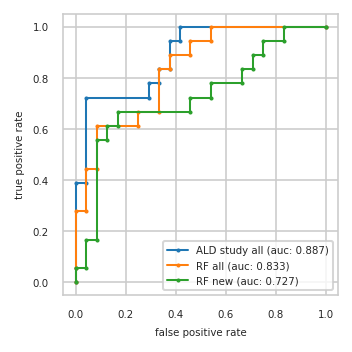

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.389  0.000 0.278  0.042 0.056
3          0.042 0.389  0.042 0.278  0.042 0.167
4          0.042 0.722  0.042 0.444  0.083 0.167
5          0.292 0.722  0.083 0.444  0.083 0.556
6          0.292 0.778  0.083 0.611  0.125 0.556
7          0.333 0.778  0.250 0.611  0.125 0.611
8          0.333 0.833  0.250 0.667  0.167 0.611
9          0.375 0.833  0.333 0.667  0.167 0.667
10         0.375 0.944  0.333 0.833  0.458 0.667
11         0.417 0.944  0.375 0.833  0.458 0.722
12         0.417 1.000  0.375 0.889  0.542 0.722
13         1.000 1.000  0.458 0.889  0.542 0.778
14           NaN   NaN  0.458 0.944  0.667 0.778
15           NaN   NaN  0.542 0.944  0.667 0.833
16           NaN   NaN  0.542 1.000  0.708 0.833
17           NaN   NaN  1.000 1.000  0.708 0.889
18           NaN   NaN    NaN   NaN  0.750 0.889
19           NaN   NaN    NaN   NaN  0.750 0.944
20           NaN   NaN    NaN   NaN  0.833 0.944
21           NaN   NaN    NaN   NaN  0.833 1.000
22           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,A0A0A0MRJ7;P12259,Q13641,P51688
2,P14174,Q01995,Q9UKZ4;Q9UKZ4-2
3,P61981,P04075,K7EPJ5;O60291;O60291-2;O60291-3;O60291-4
4,P04075,Q9Y2T3;Q9Y2T3-3,Q9NUQ9
5,P09960;P09960-4,P61981,P31321
6,C9JF17;P05090,P25189;P25189-2,Q96GD0
7,P63104,P15151-2,A0A075B7B8
8,Q9Y2T3;Q9Y2T3-3,P14174,J3KSJ8;Q9UD71;Q9UD71-2


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


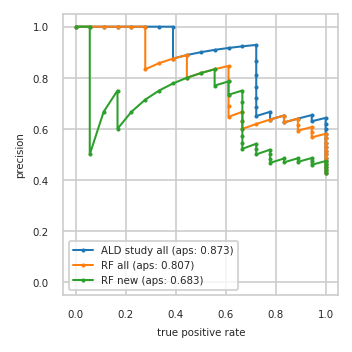

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.484 0.833
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.621 1.000     0.586 0.944     0.483 0.778
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.615 0.889     0.500 0.722
17         0.640 0.889     0.640 0.889     0.520 0.722
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.522 0.667
20         0.636 0.778     0.636 0.778     0.545 0.667
21         0.667 0.778     0.619 0.722     0.571 0.667
22         0.650 0.722     0.600 0.667     0.600 0.667
23         0.684 0.722     0.632 0.667     0.632 0.667
24         0.722 0.722     0.667 0.667     0.667 0.667
25         0.765 0.722     0.647 0.611     0.706 0.667
26         0.812 0.722     0.688 0.611     0.750 0.667
27         0.867 0.722     0.733 0.611     0.733 0.611
28         0.929 0.722     0.786 0.611     0.786 0.611
29         0.923 0.667     0.846 0.611     0.769 0.556
30         0.917 0.611     0.833 0.556     0.833 0.556
31         0.909 0.556     0.818 0.500     0.818 0.500
32         0.900 0.500     0.800 0.444     0.800 0.444
33         0.889 0.444     0.889 0.444     0.778 0.389
34         0.875 0.389     0.875 0.389     0.750 0.333
35         1.000 0.389     0.857 0.333     0.714 0.278
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


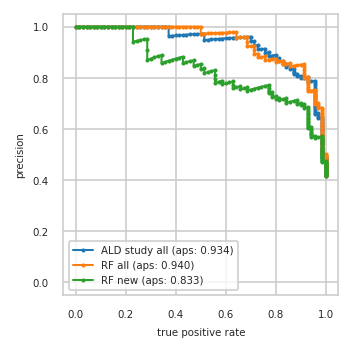

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


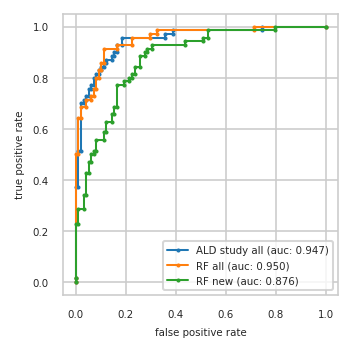

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}